In [2]:
%matplotlib inline

## The Task for the AI

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images. We will use the Keras Python API with TensorFlow as the backend.

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [3]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [4]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook.

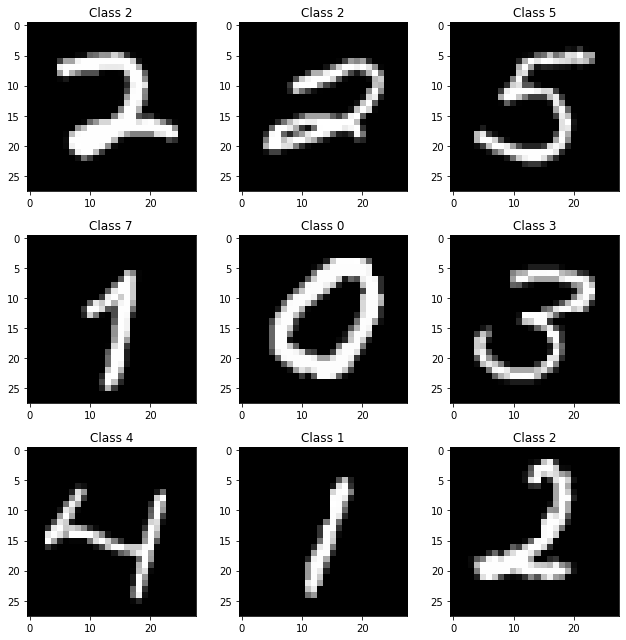

In [5]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

In [6]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!        
matprint(X_train[num])

0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  0  
0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  0  
0  0  0   0    0    0    0    0    0    0    0    0    0    7   18  196  242   56    0    0   0  0  0  0  0  0  0  0  
0  0  0   0    0    0    0    0    0    0    0    0    0   82  251  254  254  207   10    8   0  0  0  0  0  0  0  0  
0  0  0   0    0    0    0    0    0    0    0    0   17   99  247  202  232  217  161  133   0  0  0  0  0  0  0  0  
0  0  0   0    0    0    0    0    0    0    0    0   20  224  254    5   52  230  254  210  17  0  0  0  0  0  0  0  
0  0  0   0    0    0    0    0    0    0    0    0    0   40   47    1    0  166  254  171   0  0  0  0  0  0  0  0  
0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0  166  254  206  15  0  0  0  0  0  0  0  
0  0  0   0    0    0    0    0    0    0    0  

Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.

*Fun-fact! Your computer screen has three channels for each pixel: red, green, blue. Each of these channels also likely takes an 8-bit integer. 3 channels -- 24 bits total -- 16,777,216 possible colors!*

## Formatting the input data layer

Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255]. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

<img src='https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/flatten.png?raw=1' >

In [7]:
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


We then modify our classes (unique digits) to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

In [8]:
nb_classes = 10 # number of unique digits
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# Building a 3-layer fully connected network (FCN)

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/figure.png?raw=1" />

In [37]:
# The Sequential model is a linear stack of layers and is very common.
model = Sequential()
model.add(Dense(512, input_shape=(784,), activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [38]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
model.fit(X_train, Y_train, epochs=5, batch_size=10)

Epoch 1/5
6000/6000 [==============================] - 39s 6ms/step - loss: 0.1890 - accuracy: 0.9428
Epoch 2/5
6000/6000 [==============================] - 38s 6ms/step - loss: 0.0946 - accuracy: 0.9712
Epoch 3/5
6000/6000 [==============================] - 38s 6ms/step - loss: 0.0714 - accuracy: 0.9791
Epoch 4/5
6000/6000 [==============================] - 38s 6ms/step - loss: 0.0566 - accuracy: 0.9832
Epoch 5/5
6000/6000 [==============================] - 38s 6ms/step - loss: 0.0495 - accuracy: 0.9857


In [30]:
model.evaluate(X_test,Y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0997 - accuracy: 0.9762


[0.09966032207012177, 0.9761999845504761]

In [32]:
y_pred=model.predict(X_test)

In [33]:
from sklearn.metrics import r2_score
r2_score(Y_test,y_pred)

0.9572935072048303

In [34]:
y_pred1=model.predict(X_train)

In [36]:
from sklearn.metrics import r2_score
r2_score(Y_train,y_pred1)

0.9789067989564961